<a href="https://colab.research.google.com/github/KolosovKirillIT/NIS/blob/main/Research_seminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Prediction of a student's grade**

Dataset link: https://archive.ics.uci.edu/static/public/320/student+performance.zip


**EDA**

---



1. Загружаем данные

In [ ]:
pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=d131ded98a8a18a61268a2932dd41d734f855a42bc50a863451183e02b62a404
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import numpy as np
import pandas as pd
import zipfile
import wget
import matplotlib.pyplot as plt


link = 'https://archive.ics.uci.edu/static/public/320/student+performance.zip'
name = wget.download(link)

with zipfile.ZipFile(name, 'r') as first_zip: #открываем зип и находим в нем файл
  for file in first_zip.namelist():
    if file == 'student.zip':
     with first_zip.open(file) as inner_zip_file:
      inner_zip = zipfile.ZipFile(inner_zip_file)
      inner_zip.extractall('student/')
      inner_zip.printdir()
      data = pd.read_csv('student/student-por.csv', sep=";")
data.head()

File Name                                             Modified             Size
student-mat.csv                                2012-04-12 11:38:38        56993
student-por.csv                                2015-07-20 10:18:42        93220
student-merge.R                                2015-07-20 11:38:52          269
student.txt                                    2015-07-20 11:39:16         3206


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


2. Обработаем значения

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

Проверим, есть ли нулевые строки или пропущенные значения:


In [ ]:
data.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [ ]:
data = data.drop_duplicates() #удаляем повторения
sh = data.shape
print("Total number of Rows in the dataset : {}".format(sh[0]))
print("Total number of columns in the dataset : {}".format(sh[1]))

Total number of Rows in the dataset : 649
Total number of columns in the dataset : 33


Аномалии в данных нет, а значит можно приступать к анализу

---



In [ ]:
import seaborn as sns

correlation = data.corr() #строим попарную зависимость между столбцами
correlation.style.background_gradient(cmap='coolwarm')

<ipython-input-6-c271c6014534>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
age,1.000000,-0.107832,-0.121050,0.034490,-0.008415,0.319968,-0.020559,-0.004910,0.112805,0.134768,0.086357,-0.008750,0.149998,-0.174322,-0.107119,-0.106505
Medu,-0.107832,1.000000,0.647477,-0.265079,0.097006,-0.172210,0.024421,-0.019686,0.009536,-0.007018,-0.019766,0.004614,-0.008577,0.260472,0.264035,0.240151
Fedu,-0.121050,0.647477,1.000000,-0.208288,0.050400,-0.165915,0.020256,0.006841,0.027690,0.000061,0.038445,0.044910,0.029859,0.217501,0.225139,0.211800
traveltime,0.034490,-0.265079,-0.208288,1.000000,-0.063154,0.097730,-0.009521,0.000937,0.057454,0.092824,0.057007,-0.048261,-0.008149,-0.154120,-0.154489,-0.127173
studytime,-0.008415,0.097006,0.050400,-0.063154,1.000000,-0.147441,-0.004127,-0.068829,-0.075442,-0.137585,-0.214925,-0.056433,-0.118389,0.260875,0.240498,0.249789
failures,0.319968,-0.172210,-0.165915,0.097730,-0.147441,1.000000,-0.062645,0.108995,0.045078,0.105949,0.082266,0.035588,0.122779,-0.384210,-0.385782,-0.393316
famrel,-0.020559,0.024421,0.020256,-0.009521,-0.004127,-0.062645,1.000000,0.129216,0.089707,-0.075767,-0.093511,0.109559,-0.089534,0.048795,0.089588,0.063361
freetime,-0.004910,-0.019686,0.006841,0.000937,-0.068829,0.108995,0.129216,1.000000,0.346352,0.109904,0.120244,0.084526,-0.018716,-0.094497,-0.106678,-0.122705
goout,0.112805,0.009536,0.027690,0.057454,-0.075442,0.045078,0.089707,0.346352,1.000000,0.245126,0.388680,-0.015741,0.085374,-0.074053,-0.079469,-0.087641
Dalc,0.134768,-0.007018,0.000061,0.092824,-0.137585,0.105949,-0.075767,0.109904,0.245126,1.000000,0.616561,0.059067,0.172952,-0.195171,-0.189480,-0.204719


В первой модели будем прогнозировать итоговую оценку за курс (G3) на основании количества времени, проведенного за учебой в неделю (study time - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours). Построим для начала линейную регрессию

In [ ]:
from sklearn.model_selection import train_test_split

X = data['studytime'].to_numpy()
Y = data['G3'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size =0.2, random_state = 43)

In [ ]:
from sklearn.linear_model import LinearRegression
import scipy.linalg as sla

A = np.ones(X_train.size) #находим коэффициенты
A = A.reshape(X_train.size, 1)
X = X_train.reshape(X_train.size, 1)
Y = y_train.reshape(X_train.size, 1)
train = np.concatenate((X, A), axis = 1)
p1 = np.dot(np.dot(sla.inv(np.dot(train.T, train)), train.T), y_train)
print(p1[0], 'x +', p1[1])

model = LinearRegression().fit(X, Y)
coef_sklearn = model.coef_.T
print(f'Коэффициенты рассчитанные с использованием библиотеки sklearn {coef_sklearn, model.intercept_}')

1.053309493440232 x + 9.919608691690964
Коэффициенты рассчитанные с использованием библиотеки sklearn (array([[1.05330949]]), array([9.91960869]))


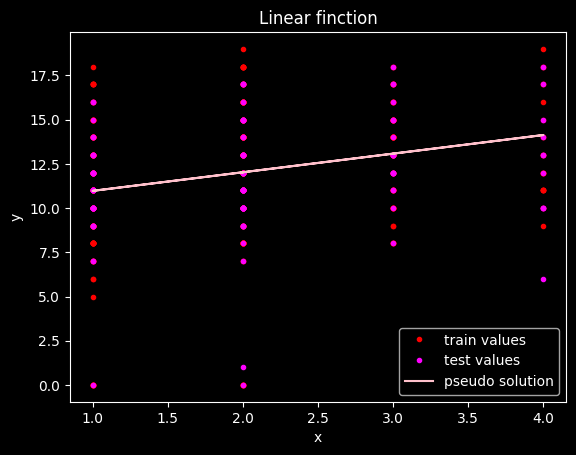

In [ ]:
plt.style.use('dark_background')
k = p1[0]
b = p1[1]
X_train.reshape(X_train.size)
X_test = X_test
y_test = y_test
y_res = k*X_train + b
plt.plot(X_train, y_train, ".",color='red', label='train values')
plt.plot(X_test, y_test, ".", color='magenta', label='test values')
plt.plot(X_train, y_res, color='pink', label='pseudo solution')
plt.title('Linear finction')
plt.ylabel('y')
plt.xlabel('x')
plt.legend()
plt.show()

Попробуем построить нелинейную функцию

In [ ]:
def updated_f(x):
    cur = 1
    res = 0
    for c in coeff:
        res += c * cur
        cur *= x
    return res

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


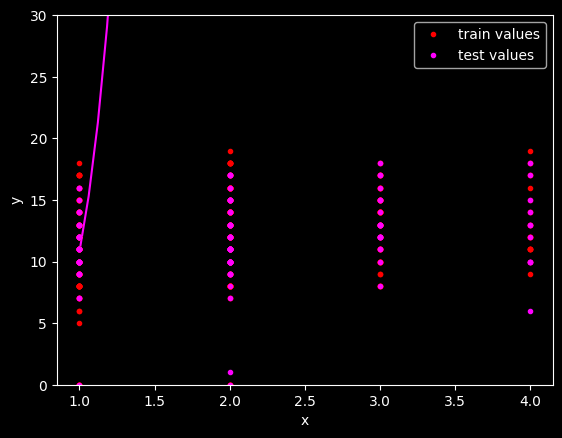

In [ ]:
coeff = np.polyfit(X_train, y_train, 6) #строим полином 6 степени
xn = np.linspace(1, 4)
yn = updated_f(xn)
plt.plot(xn, yn, color='magenta')
plt.plot(X_train, y_train, ".",color='red', label='train values')
plt.plot(X_test, y_test, ".", color='magenta', label='test values')
plt.ylim([0, 30])
plt.ylabel('y')
plt.xlabel('x')
plt.legend()
plt.show()

Получили, что в линейном случае наклон у прямой положительной, то есть при увеличении количества часов, проведенных за учебой, растет итоговая оценка за курс. При попытке приблизить многочленом большей степени сохраняется такая же логика, однако функция слишком сильно приближается к распределению оценок при значении параметра studytime = 1.



---



Модель 2: поопробуем предсказать значение параметра **go out** - going out with friends (numeric: from 1 - very low to 5 - very high) на основе следующих параметров: **Dalc** - workday alcohol consumption (numeric: from 1 - very low to 5 - very high), **Walc** - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high), **absences** - number of school absences (numeric: from 0 to 93), **freetime** - free time after school (numeric: from 1 - very low to 5 - very high)

In [ ]:
x1 = data['Dalc'].to_numpy()
x2 = data['Walc'].to_numpy()
x3 = data['freetime'].to_numpy()
x4 = data['absences'].to_numpy()
X = np.array([x1, x2, x3, x4]).T

y = data['goout'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = LinearRegression().fit(X_train, y_train)
coef_sklearn = model.coef_.T
print('y =', model.intercept_, coef_sklearn[0] ,'* x_1 +' , coef_sklearn[1], '* x_2 +', coef_sklearn[2], '* x_3 +', coef_sklearn[3], '* x_4')

y = 1.418199098540174 -0.03468399063350707 * x_1 + 0.34012822960443007 * x_2 + 0.3350793416284146 * x_3 + 0.0043975933220913865 * x_4


Мы получили следующий (вроде как вполне логичный) результат: параметр go out положительно зависит от freetime и weekend alchocol consumption в наибольшей степени: weekday alcohol consumption обычно происходит вне дома и в компании с друзьями, а чем больше свободного времени, тем больше возможностей погулять. Кроме того, частота прогулок почти не зависит от числа пропусков школы и daily alcohol consumption



---



Модель 3: попробуем решить задачу классификации путем применения дерева решений. Так как разброс итоговых оценок в целых 20 баллов является слишком большим, преобразуем данные по другим категориям:

*   1 - 10: 1
*   11 - 20: 2

Тогда получится, что итоговые оценки ранжируются по шкале от 1 до 2. Добавим в data столбец result с таким ранжированием, а затем удалим столбы с оценками, которые не потребуются для анализа (в данном случае оставлены параметры **study time** - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours) и **failures** - number of past class failures (numeric: n if 1<=n<3, else 4)

In [ ]:
def check(g):
  if g < 11:
    return 1
  elif g < 21:
    return 2

In [ ]:
result = []

for index, row in data.iterrows():
  g = row['G3']
  result.append(check(g))

data['result'] = result #добавляем новый столбец
data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,result
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,4,0,11,11,2
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,2,9,11,11,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,6,12,13,12,2
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,0,14,14,14,2
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,0,11,13,13,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,4,2,1,2,5,4,10,11,10,1
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,3,4,1,1,1,4,15,15,16,2
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,5,6,11,12,9,1
647,MS,M,17,U,LE3,T,3,1,services,services,...,4,5,3,4,2,6,10,10,10,1


In [ ]:
data = data.drop(columns='G1')
data = data.drop(columns='G2')
data = data.drop(columns='G3')
data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,result
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,4,2
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,2,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,6,2
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,0,2
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,yes,no,5,4,2,1,2,5,4,1
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,yes,no,4,3,4,1,1,1,4,2
646,MS,F,18,U,GT3,T,1,1,other,other,...,no,no,1,1,1,1,1,5,6,1
647,MS,M,17,U,LE3,T,3,1,services,services,...,yes,no,2,4,5,3,4,2,6,1


In [ ]:
import seaborn as sns

correlation = data.corr()
correlation.style.background_gradient(cmap='coolwarm')

<ipython-input-19-c271c6014534>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,result
age,1.000000,-0.107832,-0.121050,0.034490,-0.008415,0.319968,-0.020559,-0.004910,0.112805,0.134768,0.086357,-0.008750,0.149998,-0.163507
Medu,-0.107832,1.000000,0.647477,-0.265079,0.097006,-0.172210,0.024421,-0.019686,0.009536,-0.007018,-0.019766,0.004614,-0.008577,0.231704
Fedu,-0.121050,0.647477,1.000000,-0.208288,0.050400,-0.165915,0.020256,0.006841,0.027690,0.000061,0.038445,0.044910,0.029859,0.223818
traveltime,0.034490,-0.265079,-0.208288,1.000000,-0.063154,0.097730,-0.009521,0.000937,0.057454,0.092824,0.057007,-0.048261,-0.008149,-0.120917
studytime,-0.008415,0.097006,0.050400,-0.063154,1.000000,-0.147441,-0.004127,-0.068829,-0.075442,-0.137585,-0.214925,-0.056433,-0.118389,0.195444
failures,0.319968,-0.172210,-0.165915,0.097730,-0.147441,1.000000,-0.062645,0.108995,0.045078,0.105949,0.082266,0.035588,0.122779,-0.431292
famrel,-0.020559,0.024421,0.020256,-0.009521,-0.004127,-0.062645,1.000000,0.129216,0.089707,-0.075767,-0.093511,0.109559,-0.089534,0.043305
freetime,-0.004910,-0.019686,0.006841,0.000937,-0.068829,0.108995,0.129216,1.000000,0.346352,0.109904,0.120244,0.084526,-0.018716,-0.119606
goout,0.112805,0.009536,0.027690,0.057454,-0.075442,0.045078,0.089707,0.346352,1.000000,0.245126,0.388680,-0.015741,0.085374,-0.070097
Dalc,0.134768,-0.007018,0.000061,0.092824,-0.137585,0.105949,-0.075767,0.109904,0.245126,1.000000,0.616561,0.059067,0.172952,-0.148842


In [ ]:
from sklearn import tree

y = data['result'].to_numpy()
data_x = data.iloc[:, 13:15]
X = data_x.to_numpy()


[Text(0.4230769230769231, 0.875, 'x[1] <= 0.5\ngini = 0.423\nsamples = 649\nvalue = [197, 452]'),
 Text(0.15384615384615385, 0.625, 'x[0] <= 1.5\ngini = 0.333\nsamples = 549\nvalue = [116, 433]'),
 Text(0.07692307692307693, 0.375, 'gini = 0.425\nsamples = 163\nvalue = [50, 113]'),
 Text(0.23076923076923078, 0.375, 'x[0] <= 2.5\ngini = 0.283\nsamples = 386\nvalue = [66, 320]'),
 Text(0.15384615384615385, 0.125, 'gini = 0.316\nsamples = 264\nvalue = [52, 212]'),
 Text(0.3076923076923077, 0.125, 'gini = 0.203\nsamples = 122\nvalue = [14, 108]'),
 Text(0.6923076923076923, 0.625, 'x[1] <= 2.5\ngini = 0.308\nsamples = 100\nvalue = [81, 19]'),
 Text(0.5384615384615384, 0.375, 'x[0] <= 3.5\ngini = 0.331\nsamples = 86\nvalue = [68, 18]'),
 Text(0.46153846153846156, 0.125, 'gini = 0.337\nsamples = 84\nvalue = [66, 18]'),
 Text(0.6153846153846154, 0.125, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.8461538461538461, 0.375, 'x[0] <= 1.5\ngini = 0.133\nsamples = 14\nvalue = [13, 1]'),
 Text(

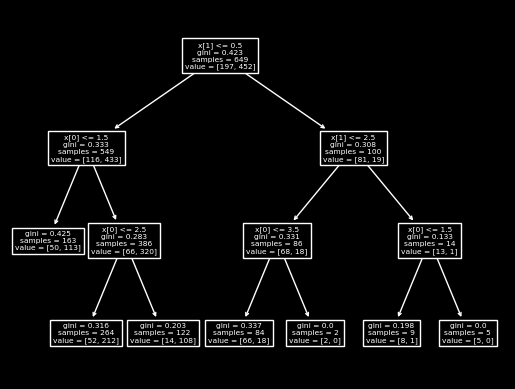

In [ ]:

clf = tree.DecisionTreeClassifier(max_depth=3) #строим дерево
clf = clf.fit(X, y)
tree.plot_tree(clf)

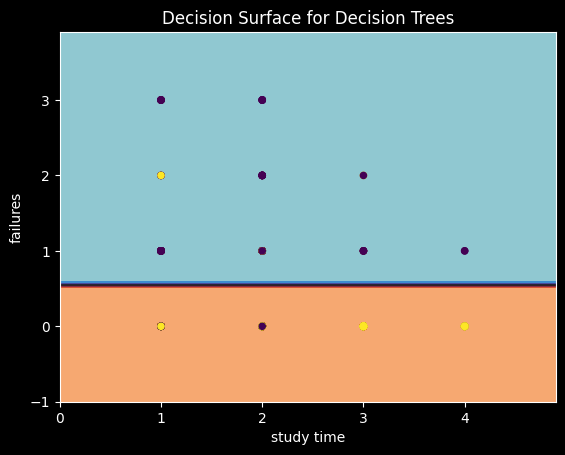

In [ ]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='icefire') #построение графика
plt.scatter(X[:, 0], X[:, 1], c=y, s=20)
plt.xlabel('study time')
plt.ylabel('failures')
plt.title('Decision Surface for Decision Trees')
plt.show()